In [1]:
%matplotlib inline
%load_ext memory_profiler
import time
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LSHForest
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import neighborsMinHash as kneighbors
from neighborsMinHash.util import create_dataset
from neighborsMinHash.util import create_dataset_fixed_nonzero
from neighborsMinHash.util import measure_performance
from neighborsMinHash.util import plotData
from neighborsMinHash.util import accuracy_and_time



import random

from scipy.sparse import dok_matrix
from scipy.sparse import rand
from scipy.sparse import vstack

from sklearn.random_projection import SparseRandomProjection

# import pyflann
import annoy

In [2]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
%time %memit datasetBursi = vectorizer.transform( graphs )

peak memory: 278.86 MiB, increment: 183.98 MiB
CPU times: user 17.1 s, sys: 64 ms, total: 17.2 s
Wall time: 18.2 s


 // Computed on Intel i5-5200U 2.2 GHz, 8 GB RAM, Ubuntu Linux 14.04

Computed on Intel i5-6600 3.3 GHz, 16 GB RAM, Ubuntu Linux 14.04

In [3]:
benchmarkResults200 = benchmarkNearestNeighorAlgorithms(datasetBursi, n_neighbors = 10, reduce_dimensions_to=200)
benchmarkResults400 = benchmarkNearestNeighorAlgorithms(datasetBursi, n_neighbors = 10, reduce_dimensions_to=400)
benchmarkResults800 = benchmarkNearestNeighorAlgorithms(datasetBursi, n_neighbors = 10, reduce_dimensions_to=800)
benchmarkResults1600 = benchmarkNearestNeighorAlgorithms(datasetBursi, n_neighbors = 10, reduce_dimensions_to=1600)

In [ ]:
label = ["sklearn", "minHash", "minHash_fast", "lhsf", "annoy", "ball tree", "KDTree", "FLANN", "PANNS", 
        "NearPy", "KGraph", "Nmslib", "RPForest"]
xticks=["200", "400", "800", "1600"]
xlabel="Number of projected dimensions. If dataset could handle sparse data, then no projection is used."
ylabel="Time in seconds"
data = [benchmarkResults200[2], benchmarkResults400[2], benchmarkResults800[2], benchmarkResults1600[2]]
title = "Query time for 10-neighbors of all instances for the bursi dataset"

#### Accuracy

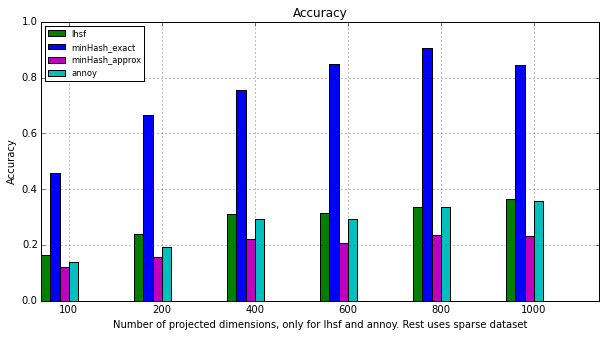

In [6]:
data = [benchmarkResults200[0], benchmarkResults400[0], benchmarkResults800[0], benchmarkResults1600[0]]
title = "Accuracy for 10-neighbors of all instances for the bursi dataset"
plotDataBenchmark(data=data, label=label, xticks=xticks, xlabel=xlabel, ylabel=ylabel, title=title, log=False)

#### Fitting time

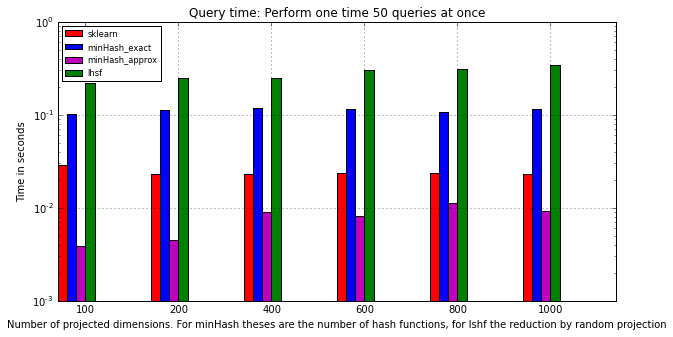

In [4]:
data = [benchmarkResults200[1], benchmarkResults400[1], benchmarkResults800[1], benchmarkResults1600[1]]
title = "Fitting time for the bursi dataset"
plotDataBenchmark(data=data, label=label, xticks=xticks, xlabel=xlabel, ylabel=ylabel, title=title, log=False)

#### Query time

In [ ]:
data = [benchmarkResults200[2], benchmarkResults400[2], benchmarkResults800[2], benchmarkResults1600[2]]
title = "Query time for 10-neighbors of all instances for the bursi dataset"
plotDataBenchmark(data=data, label=label, xticks=xticks, xlabel=xlabel, ylabel=ylabel, title=title)

Cintext: dhgfsdgfshdfs

**Take away message:** approx is not so good

#### Fitting and query time

In [ ]:
for i in xrange(len(benchmarkResults[1])):
        benchmarkResults[1][i] += benchmarkResults[2][i]
data = [benchmarkResults200[1], benchmarkResults400[1], benchmarkResults800[1], benchmarkResults1600[1]]
title = "Fitting and query time for the bursi dataset"
plotDataBenchmark(data=data, label=label, xticks=xticks, xlabel=xlabel, ylabel=ylabel, title=title, log=False)